# Exploring Kicker Data

## Prepare Data

Get seasons wise kickers and pro bowl data with player and game information

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.mlab as mlab
from mysql.connector import errorcode
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output
from IPython.html.widgets import *
import plotly as py
import plotly.graph_objs as go
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import os
import json
import time
import pickle
import requests

%matplotlib inline

C:\Users\deeka\Anaconda3\envs\GTU\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
CONFIG = {
    'user': 'db_gtown_2018',
    'password': '***',
    'port': '3306',
    'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
    'database': 'db_nfl',
    'raise_on_warnings': True,
}

QUERY = """SELECT 
        FKICKER,
        PLAYER.pname AS PLAYER_NAME,COND,SURF,FGXP AS TYPE,
        Percentage.GID,GAME.SEAS AS SEASON,        
        ((SUM(SUCCESS) / COUNT(*)) * 100) AS SUCCESS_PRCNTG,
        ((SUM(BLOCKED) / COUNT(*)) * 100) AS BLOCKED_PRCNTG,
        COUNT(*) AS PLAY_COUNT,
        CASE
            WHEN SUM(HIGH_PRESSURE) = 0 THEN 0
            ELSE ((SUM(HIGH_PRESSURE_SUCCESS) / SUM(HIGH_PRESSURE)) * 100)
        END AS HIGH_PRESSURE_SUCCESS_PRCNTG,
        SUM(HIGH_PRESSURE) AS HIGH_PRESSURE_COUNT,
        CASE
            WHEN SUM(LONG_DIST) = 0 THEN 0
            ELSE ((SUM(LONG_DIST_SUCCESS) / SUM(LONG_DIST)) * 100)
        END AS LONG_DIST_SUCCESS_PRCNTG, 
        SUM(LONG_DIST) AS LONG_DIST_COUNT,
        TEMP,
        HUMD,
        WSPD,       
        (GAME.SEAS - PLAYER.start) AS YEARS_PLAYED,
        height,
        weight,
        PLAYER.forty,
        PLAYER.bench,
        PLAYER.vertical,
        PLAYER.broad,
        PLAYER.shuttle,
        PLAYER.cone,
        PLAYER.arm,
        PLAYER.hand,
        PLAYER.dcp,
        DPOS AS DRAFT_POSITION,
        (SELECT 
                (TO_DAYS(NOW()) - TO_DAYS(STR_TO_DATE(dob, '%m/%d/%Y'))) / 365
            FROM
                PLAYER P
            WHERE
                P.player = FKICKER) AS AGE_YEARS
        FROM
        (SELECT 
            FGXP,
                PBP.GID,
                PBP.FKICKER,
                CASE
                    WHEN GOOD = 'Y' THEN 1
                    ELSE 0
                END AS SUCCESS,
                CASE
                    WHEN UPPER(DETAIL) LIKE '%BLOCKED%' THEN 1
                    ELSE 0
                END AS BLOCKED,
                CASE
                    WHEN
                        QTR IN ('2' , '4') AND MIN <= 2
                            AND (PTSO - PTSD) >= - 3
                    THEN
                        1
                    ELSE 0
                END AS HIGH_PRESSURE,
                CASE
                    WHEN
                        QTR IN ('2' , '4') AND MIN <= 2
                            AND (PTSO - PTSD) >= - 3
                            AND GOOD = 'Y'
                    THEN
                        1
                    ELSE 0
                END AS HIGH_PRESSURE_SUCCESS,
                CASE
                    WHEN DIST >= 50 THEN 1
                    ELSE 0
                END AS LONG_DIST,
                CASE
                    WHEN DIST >= 50 AND GOOD = 'Y' THEN 1
                    ELSE 0
                END AS LONG_DIST_SUCCESS,
                DIST - (100 - CASE
                    WHEN YFOG = '' THEN '98'
                    ELSE YFOG
                END) AS YDS_BEHIND_LOS
        FROM
            PBP
        LEFT OUTER JOIN PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
        WHERE TYPE = 'FGXP' AND POS1 = 'K' AND DIST >= 35) AS Percentage
        LEFT OUTER JOIN PLAYER PLAYER ON Percentage.FKICKER = PLAYER.PLAYER
        LEFT OUTER JOIN GAME ON Percentage.GID = GAME.GID
        GROUP BY FKICKER , Percentage.GID
        ORDER BY FKICKER , Percentage.GID;"""

FEATURES = ['FKICKER','PLAYER_NAME','COND','SURF','TYPE','GID','SEASON','SUCCESS_PRCNTG','BLOCKED_PRCNTG','PLAY_COUNT',
        'HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT',
        'TEMP','HUMD','WSPD',
        'YEARS_PLAYED','height','weight','forty','bench',
        'vertical','broad','shuttle','cone',
        'arm','hand','dcp','DRAFT_POSITION','AGE_YEARS']


def fetch_data():   
    try:
        cnx = mysql.connector.connect(**CONFIG)
        cursor = cnx.cursor()
        #Let's read all the rows in the table
        cursor.execute(QUERY)
        #specify the attributes that you want to display
        df = DataFrame(cursor.fetchall())    
        df.columns = FEATURES
        cnx.commit()
    except mysql.connector.Error as err:
        if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
            print("Something is wrong with your user name or password")
        elif err.errno == errorcode.ER_BAD_DB_ERROR:
            print("Database does not exist")
        else:
            print(err)
    else:
        
        return df
        cursor.close()
        cnx.close()
DATA = fetch_data()

## Handle missing data

In [3]:
# Check number of missing values
DATA.isnull().sum()

FKICKER                         0
PLAYER_NAME                     0
COND                            0
SURF                            0
TYPE                            0
GID                             0
SEASON                          0
SUCCESS_PRCNTG                  0
BLOCKED_PRCNTG                  0
PLAY_COUNT                      0
HIGH_PRESSURE_SUCCESS_PRCNTG    0
HIGH_PRESSURE_COUNT             0
LONG_DIST_SUCCESS_PRCNTG        0
LONG_DIST_COUNT                 0
TEMP                            0
HUMD                            0
WSPD                            0
YEARS_PLAYED                    0
height                          0
weight                          0
forty                           0
bench                           0
vertical                        0
broad                           0
shuttle                         0
cone                            0
arm                             0
hand                            0
dcp                             0
DRAFT_POSITION

There are no missing data

## Analyse features

### Analyse Weather conditions

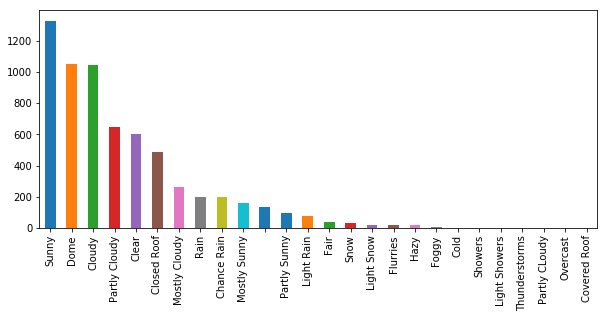

In [4]:
plt.figure(figsize=(10,4))
DATA["COND"].value_counts().plot(kind='bar')

too many weather conditions, map these conditions to fewer categories (<b>binning</b>)

NORMAL_WEATHER     5721
HARD_WEATHER        308
EXTREME_WEATHER     262
UNKNOWN_WEATHER     137
Name: COND, dtype: int64

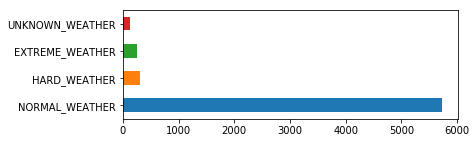

In [5]:
WeatherConditionsDifficultyLevel = { 
    'NORMAL_WEATHER' :['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
                       'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
                       'Sunny','Mostly Sunny','Partly Sunny'],
    'HARD_WEATHER'   :['Chance Rain','Light Rain','Flurries','Light Snow','Light Showers'],
    'EXTREME_WEATHER':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
                     'Windy','Overcast']
}

def get_weather_category(dict, text):
    if(text==''):
        return 'UNKNOWN_WEATHER'
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
DATA["COND"] = DATA.apply(lambda row: get_weather_category(WeatherConditionsDifficultyLevel, row['COND']), axis=1)
plt.figure(figsize=(6,2))
DATA["COND"].value_counts().plot(kind='barh')
DATA["COND"].value_counts()

In [6]:
DATA=pd.concat([DATA,pd.get_dummies(DATA["COND"])], axis=1)

In [7]:
DATA.apply(pd.to_numeric,errors='ignore')
DATA[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT','Is_Weather_Hard']]=DATA[['PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT','Is_Weather_Hard']].apply(pd.to_numeric)
DATA[['FKICKER','PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','HIGH_PRESSURE_COUNT','LONG_DIST_SUCCESS_PRCNTG','LONG_DIST_COUNT','Is_Weather_Hard']].head(13)

KeyError: "['Is_Weather_Hard'] not in index"

## Exploring Kicker performances with in game and between different conditions


We will figure out if there is any variance in performance of a player with in games and between different conditions<br/>
<b>H<sub>0</sub></b> : No difference in performace within and between groups<br/>
<b>H<sub>A</sub></b> : There is a difference in performace within and between groups

In [ ]:
from IPython.html.widgets import *
import plotly as py
import plotly.graph_objs as go
from IPython.core.display import display, HTML
def filterData(Player):
    p,q = Player.split(':')
    cdf= DATA[DATA['FKICKER'] == p][['FKICKER','GID','PLAY_COUNT','SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG','EXTREME_WEATHER','HARD_WEATHER','NORMAL_WEATHER']]
    #cdf[['SUCCESS_PRCNTG','BLOCKED_PRCNTG','HIGH_PRESSURE_SUCCESS_PRCNTG','LONG_DIST_SUCCESS_PRCNTG']].boxplot(return_type='axes', figsize=(12,8))
    k=2 # degrees of freedom for variance between the groups i.e. number of groups - 1 = 3- 1 = 2
    n=cdf.size - 3 # degrees of freedom for variance within the groups i.e. number of observations - number of groups
    from scipy import stats
    f, p= stats.f_oneway(cdf['SUCCESS_PRCNTG'], cdf['HIGH_PRESSURE_SUCCESS_PRCNTG'],cdf['LONG_DIST_SUCCESS_PRCNTG'])
    print('f:' + str(f) + ', p:'+ str(p)) # F= between groups/within groups
    if f>1 and p < .05:
        display(HTML("<b>Conclusion</b>: f is large and p is significantly low so we can reject H<sub>0</sub> and accept H<sub>A</sub>. Player performance varies within games and between different conditions."))
    else:
        display(HTML("<b>Conclusion</b>: Does not have enough evidence to reject H<sub>0</sub>"))
        
PLAYER_LABLES = (DATA['FKICKER'] + ":" + DATA['PLAYER_NAME']).unique()
form=interactive(filterData,Player=PLAYER_LABLES)
display(form)

## Calculate averages and consistency ratings

The ability to perform well in individual matches at critical moments is important, but consistently performing at a high level of skill creates a statistical divide between lucky players and highly skilled players. As a result, measuring empirical variance is an important aspect to determining a player’s skill level.

For averages we can consider/use player mean success percentage in each game.<br/>
To measure player consistency, we borrow a concept from probability theory called the coefficient of variation (CV). This measures a player’s standardized performance dispersion. 

CV = (Std_dev/mean)

The result of this means that lower CV values result in less variation in performance, indicating a higher degree of consistency. As the CV increases, players become less and less consistent. This means we now have an empirical range with which we can determine the ability of players to perform consistently at a given level of performance.

Consistency = 1/CV

In [ ]:
%matplotlib notebook 

def plot(choices, player=''):
    py.offline.init_notebook_mode(connected=True)

    trace=[]
    for i in range(0,len(choices)):
        if(i==0):
            color = 'rgba(100, 100, 100, .8)'
        elif(i==1):
            color = 'rgba(0, 0, 255, .8)',
        elif(i==2):
            color = 'rgba(255, 0, 0, .8)',
        elif(i==3):
            color = 'rgba(255, 255, 100, .8)'
        elif(i==4):
            color = 'rgba(255, 255, 200, .8)'
        trace.append(go.Scatter(
            x = all_results[choices[i]]['MEAN'],
            y = all_results[choices[i]]['CNTC'],
            name = choices[i],
            mode = 'markers',
            #text = 'Count: ' + str(all_results[choices[i]]['COUNT']),
            marker = dict(
                size = 5,
                color = color,
                line = dict(
                    width = .40,
                    color = 'rgb(0, 0, 0)'
                )
            )
        ))
   

    layout = dict(title = 'Consistency - Average (' + player + ')' ,
                  xaxis=dict(
                        title='Average',
                        titlefont=dict(
                            family='Courier New, monospace',
                            size=18,
                            color='#7f7f7f'
                        ),
                            zeroline = True
                       ),
                        yaxis=dict(
                            title='Consistency',
                            titlefont=dict(
                                family='Courier New, monospace',
                                size=18,
                                color='#7f7f7f'
                            ),
                            zeroline = True
                        ),

                  hovermode= 'closest',
                  #width=800,
                  #height=700,
                 )

    fig= go.Figure(data=trace, layout=layout)
    py.offline.iplot(fig)
    

all_results={}    
def filterData(kicks=0, player=''):
    global players_keys, players_values, A_DATA
    
    choices = ['All','Long Distance','High Pressure','Extreme Weather']
    for i in range(0,len(choices)):
        if(i == 0 or i==3):
            total_counter_name ='PLAY_COUNT'
            success_column_name=''
            success_percent_counter_name = 'SUCCESS_PRCNTG'
        elif(i==1):            
            total_counter_name ='LONG_DIST_COUNT'
            success_percent_counter_name = 'LONG_DIST_SUCCESS_PRCNTG'
        elif(i==2):
            total_counter_name ='HIGH_PRESSURE_COUNT'
            success_percent_counter_name = 'HIGH_PRESSURE_SUCCESS_PRCNTG'

        result = DATA[DATA[total_counter_name]!=0]
        if(i==3):
            result = DATA[DATA['EXTREME_WEATHER']==1]
            
        result['PLAYER_LABLE'] = result['FKICKER'] + ":" + result['PLAYER_NAME']
        result = result.groupby(['PLAYER_LABLE'], as_index=False).agg(
        {total_counter_name:['sum'],success_percent_counter_name:['mean','std']})
        result.columns = ['PLAYER_LABLE','COUNT','MEAN','STD']
        result.reindex(columns=sorted(result.columns))
        result['CV'] = result['STD']/result['MEAN']
        result = result[result['COUNT']>kicks]
        if(player != 'All'):
            result = result[result['PLAYER_LABLE'] == player]
        
        result['CNTC'] = 1/result['CV']
        # sclaing features
        result['MEAN'] = result['MEAN']/100
        result['CNTC'] = result['CNTC']/10
        all_results[choices[i]] = result
        
        
    plot(choices, player) 
    
PLAYER_LABLES = (DATA['FKICKER'] + ":" + DATA['PLAYER_NAME']).unique()
PLAYER_KEYS = pd.concat([pd.Series('All'),pd.Series(PLAYER_LABLES)]) 
form=interactive(filterData,kicks=(0,100,1),player=PLAYER_KEYS)
display(form)

In [ ]:
df = DATA
df.plot()
#df.plot(x='A', y='B')
#df.plot(kind='bar')


<b>Conclusion:</b> 
Above we saw in most of the cases we rejected null hypothesis, it means change of condition, distance and pressure affect performace. 
<br /><br />
We also found same in above consitency vs average plot that distance, pressure and conditions effect player performace.
<br /><br />
Pro bowl selection depend upon player performace, so it means we should select these features while making model.